In [1]:
# based on https://wroscoe.github.io/keras-lane-following-autopilot.html

import os
import urllib.request
import pickle
import numpy as np

%matplotlib inline
import matplotlib
from matplotlib.pyplot import imshow

# Get Data

In [2]:
data_url = 'https://s3.amazonaws.com/donkey_resources/indoor_lanes.pkl'
file_path, headers = urllib.request.urlretrieve(data_url)
print(file_path)

/tmp/tmplbfi48k2


In [4]:
with open(file_path, 'rb') as f:
    X, y = pickle.load(f)
print('X.shape: ', X.shape)
print('y.shape: ', y.shape)
imshow(X[0])


MemoryError: 

In [11]:
def shuffle_data(X, y):
    assert len(X) == len(y)
    p = np.random.permutation(len(X))
    return X[p], y[p]

shuffled_X, shuffled_y = shuffle_data(X, y)

[  1   1   1   1   1   1   1   1   4   0   2   3   3   4   6   7   8   8
  10  12  15  20  21  21  22  22  18  16  14  11   9   8   8   7   7   4
   3  -3  -3  -3   0  12  13  19  23   6  20  21  23  25  25  27  30  31
  31  31  31  32  32  32  32  32  32  32  33  33  33  33  33  33  33  33
  34  34  34  34  34  34  34  34  34  34  35  35  35  35  35  33  31  22
  13  -2  -4  -4  -5  -5  -5  -5  -4  -4  -3  -2  -2  -2  -2  -2  -3  -6
 -12 -16 -18 -20 -20 -20 -20 -20 -19 -18 -18 -18 -17 -16 -14 -10  -8  -6
  -6  -6  -6  -8 -15 -15 -15 -14 -12  -6  -4  -3  -2  -2   0   4   9  15
  17  27  28  31  39  42  49  51  51  54  53  54  53  50  31  17  12  -2
   3  15  17  20  28  -6 -39 -62 -66 -66 -66 -66 -67 -67 -67 -68 -69 -69
 -69 -68 -67 -43 -28 -26 -26 -29 -38 -37 -29 -12  -3  11  11  60  62  65
  65  -4]


In [13]:
test_cutoff = int(len(X) * 0.8)
val_cutoff = test_cutoff + int(len(X) * 0.1)

train_X, train_y = shuffled_X[:test_cutoff], shuffled_y[:test_cutoff]
val_X, val_y = shuffled_X[test_cutoff:val_cutoff], shuffled_y[test_cutoff:val_cutoff]
test_X, test_y = shuffled_X[val_cutoff:], shuffled_y[val_cutoff:]

len(train_X) + len(val_X) + len(test_X)

7892

In [16]:
# flip images to remove steering bias
X_flipped = np.array([np.fliplr(i) for i in train_X])
y_flipped = np.array([-i for i in train_y])
train_X = np.concatenate([train_X, X_flipped])
train_y = np.concatenate([train_y, y_flipped])
len(train_X)

12626

In [6]:
from keras.models import Sequential, load_model
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.layers import Convolution2D, MaxPooling2D


Using TensorFlow backend.


In [25]:
model = Sequential()
model.add(Convolution2D(8, (3,3), input_shape=(120, 160, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(16, (3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(32, (3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(256))
model.add(Activation('linear'))
model.add(Dropout(0.2))

model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 118, 158, 8)       224       
_________________________________________________________________
activation_10 (Activation)   (None, 118, 158, 8)       0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 59, 79, 8)         0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 57, 77, 16)        1168      
_________________________________________________________________
activation_11 (Activation)   (None, 57, 77, 16)        0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 28, 38, 16)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 26, 36, 32)        4640      
__________

# Train

In [8]:
from keras import callbacks
model_path = os.getcwd() + '/models/model.hdf5'
save_best = callbacks.ModelCheckpoint(model_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

early_stop = callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto')

callbacks_list = [save_best, early_stop]

In [33]:
model.fit(train_X, train_y, batch_size=64, epochs=4, validation_data=(val_X, val_y), callbacks=callbacks_list)

Train on 12626 samples, validate on 789 samples
Epoch 1/4
12626/12626 [==============================] - 135s - loss: 514.5137 - val_loss: 498.6842
Epoch 2/4
12626/12626 [==============================] - 133s - loss: 419.1053 - val_loss: 460.8058
Epoch 3/4
12626/12626 [==============================] - 137s - loss: 373.7868 - val_loss: 398.8303
Epoch 4/4
12626/12626 [==============================] - 139s - loss: 335.2877 - val_loss: 449.3406


# Evaluate

In [10]:
import pandas as pd
from keras.models import load_model
model = load_model(model_path)
pred_y = model.predict(test_X)
pred_y = pred_y.reshape((pred_y.shape[0],))

NameError: name 'test_X' is not defined

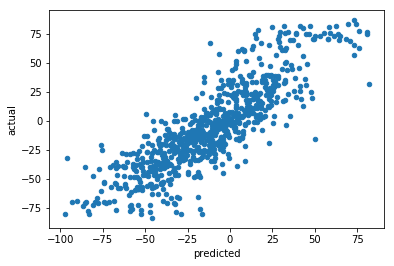

In [35]:
df = pd.DataFrame({'predicted':pred_y, 'actual':test_y})
ax = df.plot.scatter('predicted', 'actual')

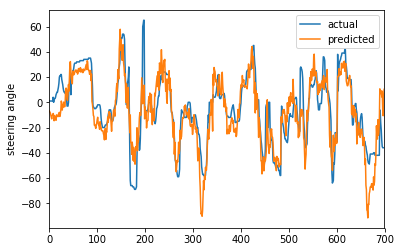

In [37]:
pred_y_2 = model.predict(X[:700])
pred_y_2 = pred_y_2.reshape((pred_y_2.shape[0],))

ax = pd.DataFrame({'predicted':pred_y_2, 'actual':y[:700]}).plot()
ax.set_ylabel('steering angle')

In [52]:
r1 = 198
r2 = 200
print(model.predict(X[r1:r2]))
print(y[r1:r2])

[[ 13.61269665]
 [-13.11321259]]
[65 -4]
